## Visualize the progress of your learning rate in PyTorch before training

In [1]:
import torchvision.utils as vutils
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ReduceLROnPlateauMy(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __init__(self, optimizer, mode='min', factor=0.1, patience=10,
                 verbose=False, threshold=1e-4, threshold_mode='rel',
                 cooldown=0, min_lr=0, eps=1e-8):
        super().__init__(optimizer, mode='min', factor=0.1, patience=10,
                         verbose=False, threshold=1e-4, threshold_mode='rel',
                         cooldown=0, min_lr=0, eps=1e-8)

    def get_lr(self):
        for param_group in self.optimizer.param_groups:
            curr_lr = param_group['lr']
        return [curr_lr]


def init_lr_scheduler(optimizer,
                      lr_scheduler='multi_step',  # learning rate scheduler
                      stepsize=[15, 30, 50, 80],  # step size to decay learning rate
                      gamma=0.5,  # learning rate decay
                      patience=5  # after how many epochs of plateau to decrease the learning rate
                      ):
    if lr_scheduler == 'single_step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize[0], gamma=gamma)
    elif lr_scheduler == 'multi_step':
        return torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=stepsize, gamma=gamma)
    elif lr_scheduler == 'on_plateau':
        return ReduceLROnPlateauMy(optimizer, mode='min', factor=gamma, patience=patience, verbose=True)
    elif lr_scheduler == 'exponential':
        return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma, last_epoch=-1)
    elif lr_scheduler == 'cossine_annealing':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=patience, eta_min=0, last_epoch=-1)
    else:
        raise ValueError('Unsupported lr_scheduler: {}'.format(lr_scheduler))


minimum learning rate for exponential is 4.496063092432672e-05
minimum learning rate for multistep is 6.194232190424719e-06


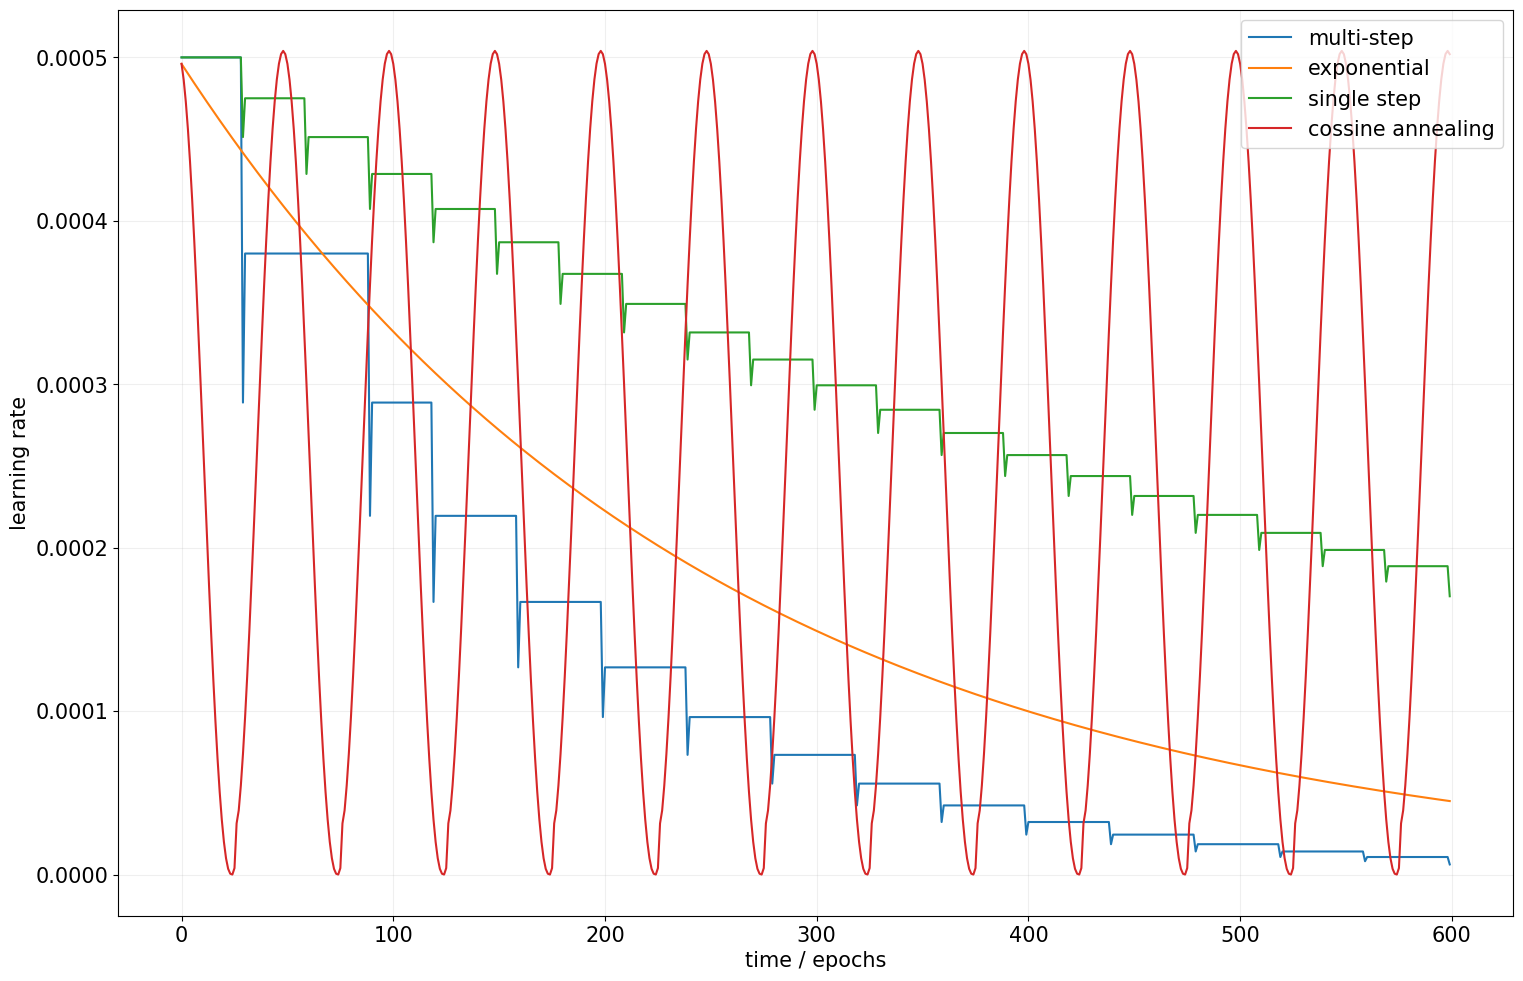

In [3]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 5e-4
milestones=[30,90, 120, 160, 200, 240,280,320, 360,400, 440, 480, 520, 560,600, 640, 680 ]

optimizer_mul = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_sgl = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_exp = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_cos = torch.optim.Adam(model.parameters(), lr=learning_rate)

#scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)


scheduler_mul = init_lr_scheduler(optimizer_mul,
                   lr_scheduler='multi_step',  # learning rate scheduler
                      stepsize=milestones,  # step size to decay learning rate
                      gamma=0.76,  # learning rate decay
                      patience=5  # after how many epochs of plateau to decrease the learning rate
                      )

scheduler_sgl = init_lr_scheduler(optimizer_sgl,
                   lr_scheduler='single_step',  # learning rate scheduler
                      stepsize=milestones,  # step size to decay learning rate
                      gamma=0.95,  # learning rate decay
                      )

scheduler_exp = init_lr_scheduler(optimizer_exp,
                   lr_scheduler='exponential',  # learning rate scheduler
                      gamma=0.996,  # learning rate decay
                      )
scheduler_cos = init_lr_scheduler(optimizer_cos,
                   lr_scheduler='cossine_annealing',  # learning rate scheduler
                      patience=25 #fter how many epochs of plateau to decrease the learning rate
                      )

lr_exp_list = []
lr_mul_list = []
lr_sgl_list = []
lr_cos_list = []

epochs = 600

for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
   # print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). 
    optimizer_mul.zero_grad()
    optimizer_sgl.zero_grad()
    optimizer_exp.zero_grad()
    optimizer_cos.zero_grad()
    

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer_mul.step()
    optimizer_sgl.step()
    optimizer_exp.step()
    optimizer_cos.step()

   
    
    #update the parameters of the scheduler. you can do this every epoch 
    scheduler_mul.step()
    scheduler_exp.step()
    scheduler_sgl.step()
    scheduler_cos.step()
    
    #for g in optimizer.param_groups:
    #    print(g['lr'])
    
    lr_mul_list.append(scheduler_mul.get_lr()[0])
    lr_exp_list.append(scheduler_exp.get_lr()[0])
    lr_sgl_list.append(scheduler_sgl.get_lr()[0])
    lr_cos_list.append(scheduler_cos.get_lr()[0])


fig=plt.figure(figsize=(18, 12), dpi= 100, facecolor='w', edgecolor='k') 
plt.rcParams.update({'font.size': 15})
plt.plot([x for x in range(0,epochs)], lr_mul_list)
plt.plot([x for x in range(0,epochs)], lr_exp_list)   
plt.plot([x for x in range(0,epochs)], lr_sgl_list)   
plt.plot([x for x in range(0,epochs)], lr_cos_list)   

plt.xlabel('time / epochs')
plt.ylabel('learning rate')
plt.grid(True, alpha=0.2)
plt.legend(('multi-step', 'exponential', 'single step','cossine annealing'),
           loc='upper right')
print('minimum learning rate for exponential is {}'.format(min(lr_exp_list)))
print('minimum learning rate for multistep is {}'.format(min(lr_mul_list)))